# Wine Prices and Ratings by Location and Year Bottled
### UMN Bootcamp Project 1 - Group 6
### Tina Kuo, Laura Hertzog, Ciera Morris, Nick Hoyer

# Intro Slide - Ciera


# Beginning of our data cleansing and formatting

In [1]:
# Import necessary tools & config
import pandas as pd
import re
import gmaps
from config import g_key
import numpy as py
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import requests
import json
from IPython.display import Image

gmaps.configure(api_key=g_key)

In [2]:
# Load our data, sourced from Kaggle, into a DataFrame
wine_data_file = "Resources/wine_data.csv"
wine_data = pd.read_csv(wine_data_file, encoding="utf-8")

wine_data.head()

,Unnamed: 0,country,description,designation,points,price (USD),province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,345,Australia,This wine contains some material over 100 year...,Rare,100,350.0,Victoria,Rutherglen,NaN,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Muscat,Chambers Rosewood Vineyards
1,7335,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,NaN,NaN,NaN,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi
2,36528,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,Krug 2002 Brut (Champagne),Champagne Blend,Krug
3,39286,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,NaN,NaN,NaN,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia
4,42197,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,NaN,Roger Voss,@vossroger,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha


# Cleaning the data and dropping null/unnecessary values

In [3]:
# Drop region 2, taster name, taster twitter handle, and unnamed column and ensure dataframe is clean/usable
clean_wine_data = wine_data.drop(["region_2", "taster_name", "taster_twitter_handle", "Unnamed: 0"], axis = 1)

# Extract the year from the title column and place it into a new column
# This is using the string extract function
clean_wine_data["Year"] = clean_wine_data["title"].str.extract("(\d{4})")

# Drop any rows that do not have a price, country, rating, or year
cleaned_wine_data = clean_wine_data.dropna(subset = ["price (USD)", "country", "points", "Year"])
cleaned_wine_data.head()

,country,description,designation,points,price (USD),province,region_1,title,variety,winery,Year
1,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi,1995
2,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Krug 2002 Brut (Champagne),Champagne Blend,Krug,2002
3,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia,2007
4,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha,2008
5,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,2010


In [4]:
# Create a cleaned up version of the df for further analysis
wine_df = cleaned_wine_data.copy()

# Change Georgia to Georgia Country to ensure Google finds lat, lng for the country of Georgia instead of the state
wine_df["country"] = wine_df["country"].replace(["Georgia"], "Georgia Country")

# Drop rows where year is greater than or equal to 1980 and less than or equal to 2020
wine_df["Year"] = wine_df["Year"].astype("int")
wine_df = wine_df[(wine_df["Year"] >= 1980) & (wine_df["Year"] <= 2020)]

wine_df.head()

,country,description,designation,points,price (USD),province,region_1,title,variety,winery,Year
1,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi,1995
2,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Krug 2002 Brut (Champagne),Champagne Blend,Krug,2002
3,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia,2007
4,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha,2008
5,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,2010


# Analyze year of wine vs. rating using a bar chart

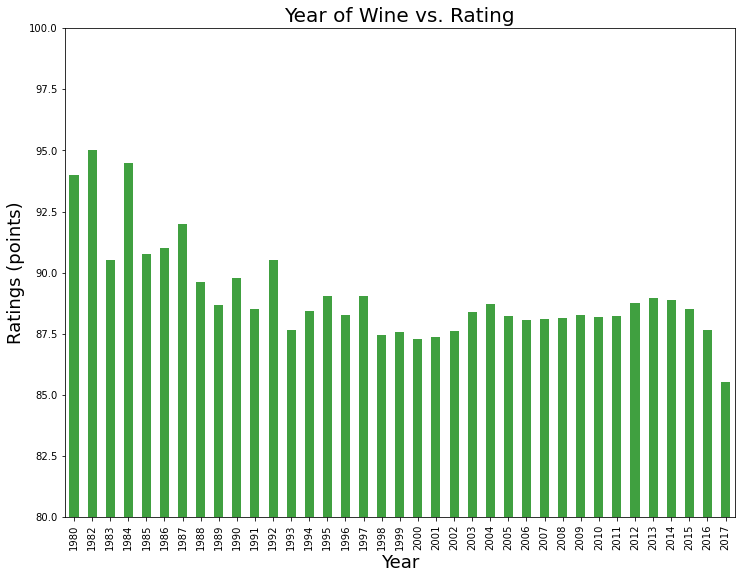

In [5]:
# Analyze and plot year of wine vs. rating
wine_year = wine_df.groupby(["Year"])
total_ratings = wine_df.groupby(["Year"]).mean()["points"]

#Reset the index for proper tick locations
total_ratings_df = total_ratings.reset_index()

# Plot the total ratings
total_ratings.plot(kind="bar", figsize = (12,9), color="g", alpha=0.75, legend=False, rot = 90)

#Assign labels and chart title
plt.title("Year of Wine vs. Rating", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Ratings (points)", fontsize = 18)
plt.ylim(80,100)

# Set tick locations
plt.xticks(py.arange(0, len(total_ratings_df)), total_ratings_df["Year"])


plt.show()

# Analyze price of wine vs. rating using a scatter plot and linear regression

The r-squared is: 0.17340116703569503


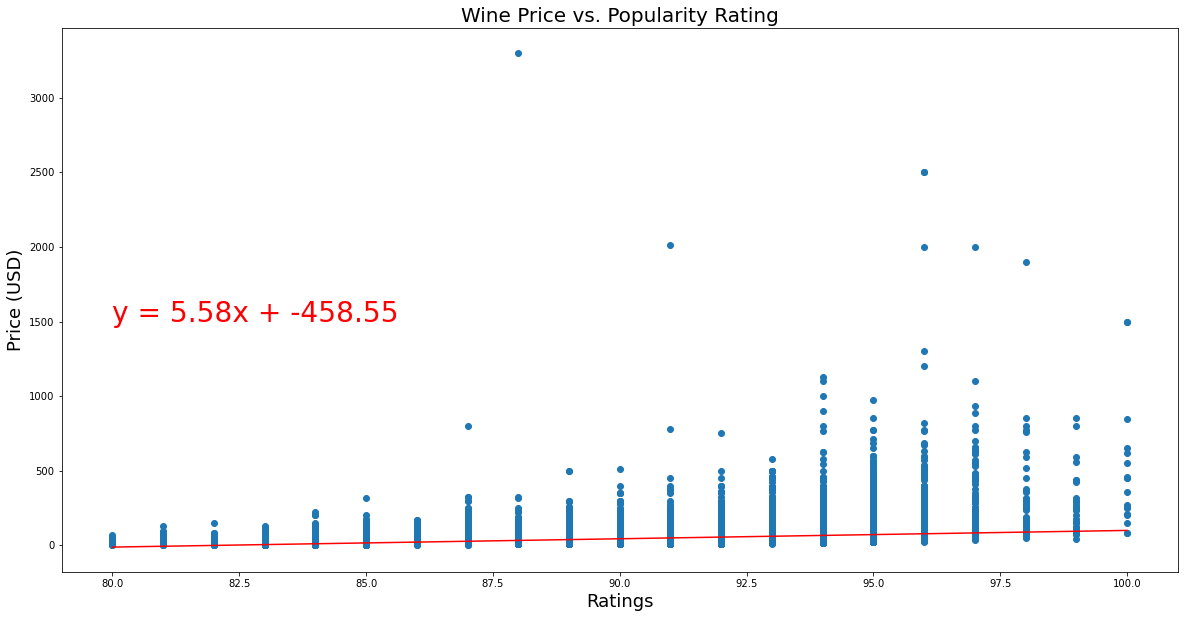

In [6]:
#Define variables
price = wine_df["price (USD)"]
ratings = wine_df["points"]

#plot figure
plt.figure(figsize = (20,10))
plt.scatter(ratings, price)

#assign labels and chart title
plt.title(f"Wine Price vs. Popularity Rating", fontsize = 20)
plt.xlabel("Ratings", fontsize = 18)
plt.ylabel("Price (USD)", fontsize =18)

# Analyze price of wine vs. rating Linear Regression
x_values= wine_df["points"]
y_values = wine_df["price (USD)"]

# Create the linregress function
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(80,1500),fontsize=28,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig('output_data/Price_Rating_linear_MT.png')

plt.show()

### Due to the large range of price values and relatively small range of rating values the visual representation between price and rating is not highly satisfying, but based on the r-value there is _some_ correlation.

# Analyze price of wines from 1980 to 2017

The r-squared is: 0.00636444736076331


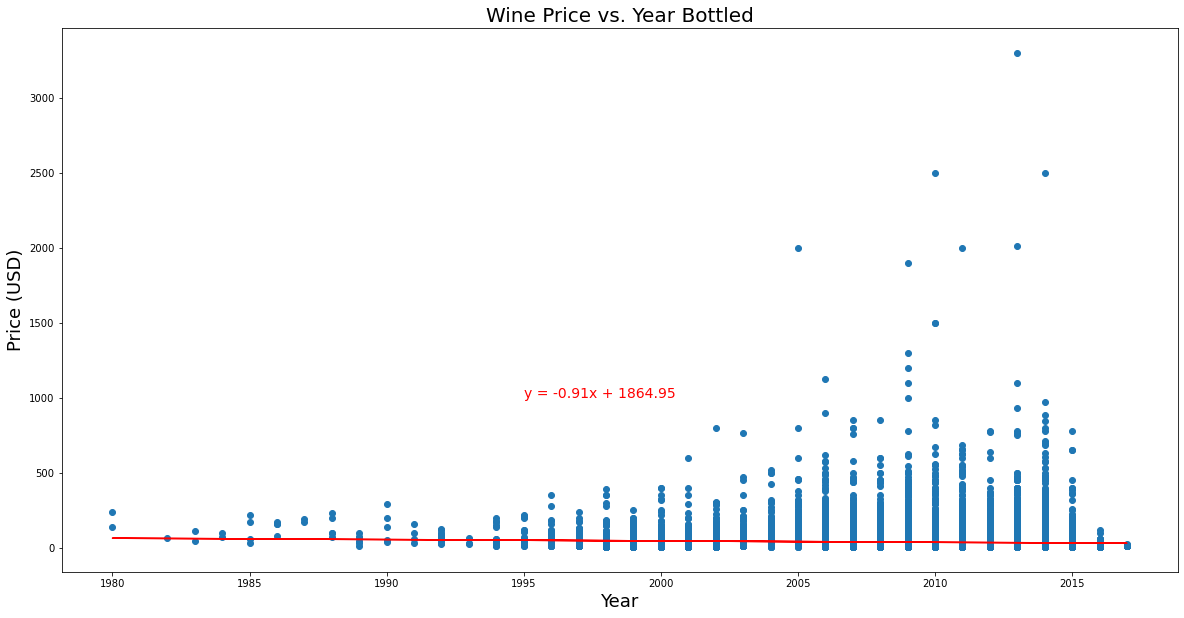

In [7]:
#Define variables
year = wine_df["Year"]
price = wine_df["price (USD)"]

#plot figure
plt.figure(figsize = (20,10))
plt.scatter(year, price)

#Assign labels and chart title
plt.title(f"Wine Price vs. Year Bottled", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)

# Analyze year of wine vs. price Linear Regression
x_values = wine_df["Year"].astype("float")
y_values = wine_df["price (USD)"]

# Create the linregress function
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1995,1000),fontsize=14,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig('output_data/Year_Price_linear_MT.png')

plt.show()

### This plot allows us to view that the majority of wine price records were taken in recent years. If we take a look at the data from 2010 to 2015, we may be able to get a better prediction of the trends in wine prices across the world.

The r-squared is: 0.004945972367877448


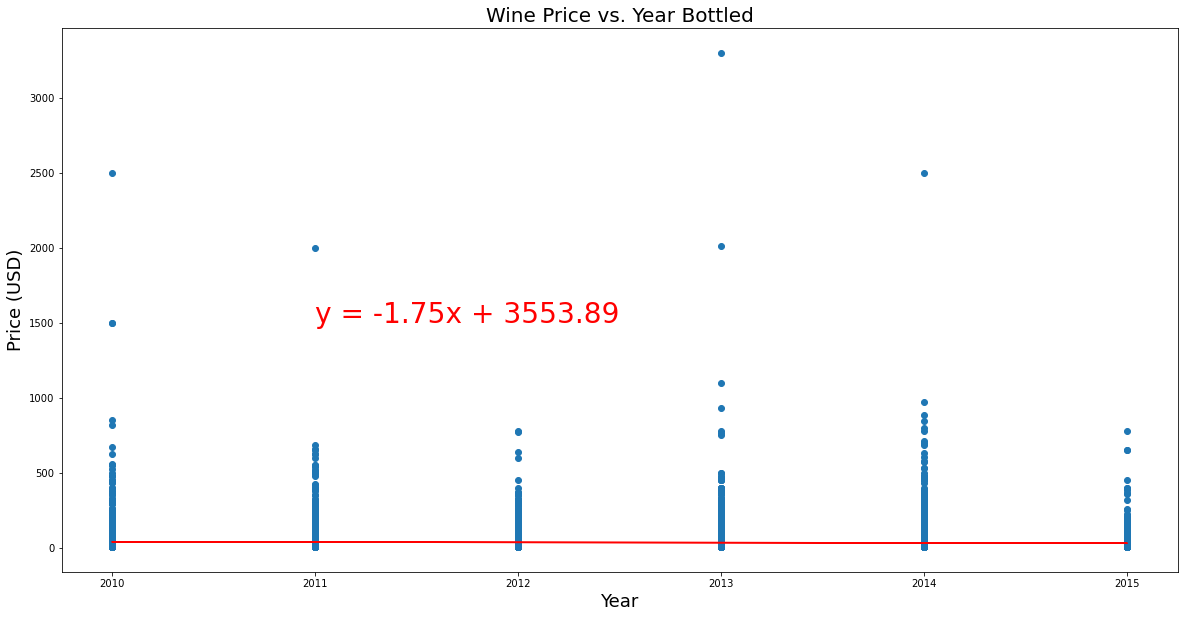

In [8]:
# Create condensed df
wine_10to15 = wine_df[(wine_df["Year"] >= 2010) & (wine_df["Year"] <= 2015)]

#Define variables
year = wine_10to15["Year"]
price = wine_10to15["price (USD)"]

#plot figure
plt.figure(figsize = (20,10))
plt.scatter(year, price)

#Assign labels and chart title
plt.title(f"Wine Price vs. Year Bottled", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)

# Analyze year of wine vs. price Linear Regression
x_values = wine_10to15["Year"].astype("float")
y_values = wine_10to15["price (USD)"]

# Create the linregress function
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2011,1500),fontsize=28,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig('output_data/2010to2015_Year_Price_linear_MT.png')

plt.show()

### Just kidding.. From 2010 to 2015, there is not a strong trend upward or downward in price of wine! 

# Prepare a summary dataframe for gmap visualization. This will help us identify which countries have the most expensive & the highest rated wines.

In [9]:
# Create a summary df for price and wine rating called wine country
# Declare the avg wine price and avg rating by country
avg_price = wine_df.groupby("country").mean()["price (USD)"]
avg_rating = wine_df.groupby("country").mean()["points"]

# Summary DF
wine_country = pd.DataFrame({
    "Avg Wine Price (USD)": avg_price,
    "Avg Wine Rating": avg_rating
})

In [10]:
# Call the Google Geocode API to retrieve lat and lng for the countries in the DataFrame
wine_country["lat"] = ""
wine_country["lng"] = ""

params = {"key": g_key}


for index, row in wine_country.iterrows():   
    
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    country = index
    
    params["address"] = f"{country}"
    
    country_lat_lng = requests.get(base_url, params=params)

    # Convert to JSON
    country_geo = country_lat_lng.json()

    # Extract lat/lng
    wine_country.loc[index, "lat"] = country_geo["results"][0]["geometry"]["location"]["lat"]
    wine_country.loc[index, "lng"] = country_geo["results"][0]["geometry"]["location"]["lng"]
    
# Show new df
wine_country.head()

,Avg Wine Price (USD),Avg Wine Rating,lat,lng
country,,,,
Argentina,24.606314,86.741230,-38.4161,-63.6167
Armenia,14.500000,87.500000,40.0691,45.0382
Australia,35.097528,88.595506,-25.2744,133.775
Austria,30.776573,90.210774,47.5162,14.5501
Bosnia and Herzegovina,12.500000,86.500000,43.9159,17.6791


# Take a look at a DataFrame of the countries with the most expensive wine, these should be visible when looking at the gmap visualization.

In [11]:
# Identify the top 10 most expensive wine countries
most_expensive = wine_country.sort_values(["Avg Wine Price (USD)"], ascending = False)
most_expensive.head(10)

,Avg Wine Price (USD),Avg Wine Rating,lat,lng
country,,,,
Switzerland,85.285714,88.571429,46.8182,8.22751
England,52.400000,91.709091,52.3555,-1.17432
Germany,42.385640,89.844508,51.1657,10.4515
Hungary,41.253521,89.267606,47.1625,19.5033
Italy,40.665835,88.718713,41.8719,12.5674
France,40.554871,88.741333,46.2276,2.21375
US,36.840300,88.602842,37.0902,-95.7129
Canada,35.723320,89.379447,56.1304,-106.347
Australia,35.097528,88.595506,-25.2744,133.775


# In order to enhance the scale for our gmap that compares wine ratings by country, we decided to reduce the total scale by subtracting 80 from the average wine ratings column. This increased the minimum value of our gmap weight scale from 0 to 80 for a more pronounced difference in point weights.

In [12]:
# Reduce the scale for wine ratings to visualize the difference betweens ratings by country
wine_country["New Rating"] = wine_country["Avg Wine Rating"] - 80

# Format ratings and prices to 2 decimals
wine_country["Avg Wine Price (USD)"] = wine_country["Avg Wine Price (USD)"].map("{:,.2f}".format)
wine_country["Avg Wine Rating"] = wine_country["Avg Wine Rating"].map("{:,.2f}".format)

wine_country.head()

,Avg Wine Price (USD),Avg Wine Rating,lat,lng,New Rating
country,,,,,
Argentina,24.61,86.74,-38.4161,-63.6167,6.741230
Armenia,14.50,87.50,40.0691,45.0382,7.500000
Australia,35.10,88.60,-25.2744,133.775,8.595506
Austria,30.78,90.21,47.5162,14.5501,10.210774
Bosnia and Herzegovina,12.50,86.50,43.9159,17.6791,6.500000


# To visualize our data, we first setup our variables and then created gmaps with a price layer and a rating layer, respectively. This will be shown through our Jupyter Notebook, as Jupyter slides does not currently support displaying interactive gmaps.

In [13]:
# Storing variables for gmap use
locations = wine_country[["lat", "lng"]]
country_rating = wine_country["New Rating"].astype(float)
country_price = wine_country["Avg Wine Price (USD)"].astype(float)

In [14]:
# Create a gmap with a heatmap layer and pins that have country and price displayed
fig = gmaps.figure(center=(30,20), zoom_level=1.5)

price_layer = gmaps.heatmap_layer(locations, weights=country_price,
                                dissipating=False, max_intensity=country_price.max(),
                                point_radius=1)

fig.add_layer(price_layer)

# Using the template add the marks to the heatmap
info_box_template = """
<dl>
<dt>Country</dt><dd>{index}</dd>
<dt>Avg Wine Price (USD)</dt><dd>{Avg Wine Price (USD)}</dd>
</dl>
"""
# Store the DataFrame Row
country_info = [info_box_template.format(index=index, **row) for index, row in wine_country.iterrows()]

# Add marker layer ontop of heat map
fig.add_layer(gmaps.symbol_layer(locations, info_box_content=country_info, stroke_opacity=0, fill_color="black", fill_opacity=.5, scale=3))


fig


Figure(layout=FigureLayout(height='420px'))

In [16]:
# Identify countries with the highest rated wine
# Avg wine ratings by country
# Include a gmap
fig = gmaps.figure(center=(30,20), zoom_level=1.5)

rating_layer = gmaps.heatmap_layer(locations, weights=country_rating,
                                dissipating=False, max_intensity=10,
                                point_radius=1)

fig.add_layer(rating_layer)

# Using the template add the marks to the heatmap
info_box_template = """
<dl>
<dt>Country</dt><dd>{index}</dd>
<dt>Avg Wine Rating</dt><dd>{Avg Wine Rating}</dd>
</dl>
"""
# Store the DataFrame Row
country_info = [info_box_template.format(index=index, **row) for index, row in wine_country.iterrows()]

# Add marker layer ontop of heat map
fig.add_layer(gmaps.symbol_layer(locations, info_box_content=country_info, stroke_opacity=0, fill_color="black", fill_opacity=.5, scale=3))


fig


Figure(layout=FigureLayout(height='420px'))

# Conclusions we found through our analysis!

#### The country with the highest average price of wine is Switzerland with an average bottle of wine priced at 85.25 dollars. <img src="Resources/switzerland.jpg" width="400">
#### The next country with the highest average price of wine is 32.85 dollars below (England), followed by Germany for price. <img src="Resources/england.jpg" width="300"><img src="Resources/germany.png." width="200">
#### The overall average price of wine for all countries analyzed is 26.64 dollars.

#### The average wine rating is 87.735 with the range is 7.9. The country with the lowest rated wine also has the cheapest wine, from Ukraine. However, the country highest rated wine does not have the highest priced wine. Outlier might be India, 90.2 average wine rating and average price is 13.3 dollars. In an earlier scatter plot there was a linear regression between wine price to year bottled. The r-squared is: 0.414, meaning there is some correlation, although it is not strong.